In [1]:
import os
import copy
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.datasets import DatasetFolder, ImageFolder
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
n_class = 3
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print('device:', device)

device: cuda:0


In [26]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((192, 256), scale=(0.9, 1.1), ratio=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((192, 256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
])

trainset = ImageFolder('car-damage-dataset/data3a/training', transform=train_transform)
valset = ImageFolder('car-damage-dataset/data3a/validation', transform=val_transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=1)

[[2 2 0 1 2 2 2 2]
 [2 2 2 2 0 1 2 2]]


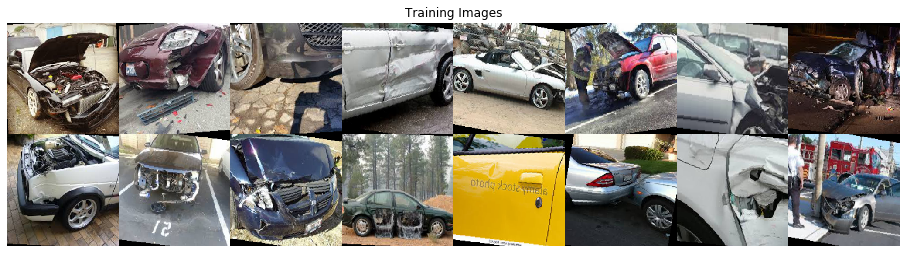

In [20]:
batch = next(iter(train_loader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:16], padding=0, normalize=True).cpu(),(1,2,0)))
print(batch[1].numpy()[:16].reshape(2,8))

In [22]:
def train(train_loader, val_loader=None, model=None, epoch=1, optimizer=None, criterion=None, early_stopping=3, device=device):
        
    best_loss = 10000000
    best_epoch = 0
    best_model_wts = None
    
    for t in range(epoch):
        
        model.train()
        
        for i_batch, batch in tqdm(enumerate(train_loader)):
            
            batch_X, batch_y = batch[0].to(device), batch[1].to(device)
            batch_y_pred = model(batch_X)
            loss = criterion(batch_y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if val_loader is not None: #evaluate on validation data
            
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i_batch, batch in enumerate(val_loader):
                    batch_X, batch_y = batch[0].to(device), batch[1].to(device)
                    batch_y_pred = model(batch_X)
                    loss = criterion(batch_y_pred, batch_y)                   
                    running_loss += loss.item() * batch_X.size()[0]
        
            epoch_loss = running_loss / len(val_loader.dataset)
            print ("epoch %d, loss %.6f"%(t, epoch_loss))
            
            if epoch_loss < best_loss: #keep track of best loss and epoch
                best_loss = epoch_loss
                best_epoch = t
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if (t - best_epoch > early_stopping): #early stopping if loss haven't improve for n=early_stopping rounds
                break
                
    if best_model_wts is not None:
        print("load best weights from epoch %d"%best_epoch)
        model.load_state_dict(best_model_wts)

In [31]:
from torchvision import models
model = models.vgg16_bn()

print(model.classifier[6].out_features) # 1000 

# Freeze training for all layers
for param in model.features.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 64),
    nn.ReLU(True),
    nn.Linear(64, n_class)
)

# num_features = model.classifier[6].in_features
# features = list(model.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(num_features, n_class)]) # Add our layer with 3 outputs
# model.classifier = nn.Sequential(*features) # Replace the model classifier

model = model.to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
print(model)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [32]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.5, 0.999))
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

criterion = nn.CrossEntropyLoss()
train(train_loader, val_loader, model=model, epoch=20, optimizer=optimizer, criterion=criterion, early_stopping=5)

31it [00:07,  4.11it/s]


epoch 0, loss 1.260324


31it [00:07,  4.11it/s]


epoch 1, loss 1.227783


31it [00:07,  4.11it/s]


epoch 2, loss 1.044031


31it [00:07,  4.11it/s]


epoch 3, loss 1.033629


31it [00:07,  4.10it/s]


epoch 4, loss 1.012220


31it [00:07,  4.10it/s]


epoch 5, loss 0.949066


31it [00:07,  4.10it/s]


epoch 6, loss 1.058328


31it [00:07,  4.10it/s]


epoch 7, loss 0.962149


31it [00:07,  4.10it/s]


epoch 8, loss 1.028965


31it [00:07,  4.10it/s]


epoch 9, loss 0.979430


31it [00:07,  4.10it/s]


epoch 10, loss 0.975729


31it [00:07,  4.10it/s]


epoch 11, loss 0.983891
load best weights from epoch 5


In [33]:
def predict(dataloader, model):
    model.eval()
    res = []
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(dataloader)):
            batch_x = batch[0].to(device)
            batch_y_pred = model(batch_x)
            _, idx = torch.max(batch_y_pred, 1)
            
            res += list(idx.cpu().numpy())
    return np.array(res)

In [34]:
result = predict(val_loader, model)

label = []
for i_batch, batch in tqdm(enumerate(val_loader)):
    label += list(batch[1].numpy())
label = np.array(label)

accuracy = sum(result==label)/len(label)
accuracy

3it [00:01,  1.76it/s]
3it [00:00,  5.78it/s]


0.5906432748538012

              precision    recall  f1-score   support

           0       0.65      0.54      0.59        48
           1       0.52      0.53      0.52        55
           2       0.61      0.68      0.64        68

    accuracy                           0.59       171
   macro avg       0.59      0.58      0.59       171
weighted avg       0.59      0.59      0.59       171



Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8cba34da58>>
Traceback (most recent call last):
  File "/home/ubuntu/.local/share/virtualenvs/car-damage-detective-VOPWCVCV/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/.local/share/virtualenvs/car-damage-detective-VOPWCVCV/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


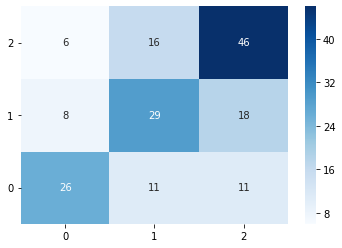

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(label, result))
ax = sns.heatmap(confusion_matrix(label, result), cmap='Blues', annot=True)
plt.yticks(rotation=0)
ax.set_ylim(0, 3)
plt.show()